In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
import gc
from datetime import datetime
import json
import sys
import platform
import hashlib
from collections import Counter

warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

from sklearn.metrics import (
    f1_score, matthews_corrcoef, accuracy_score, confusion_matrix,
    precision_score, recall_score, balanced_accuracy_score, 
    roc_auc_score, average_precision_score
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN

In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Make paths portable - use script location as reference
ROOT = Path(r"C:\Computer Science\AIMLDL\log-anomaly-detection")
FEAT_PATH = ROOT / "features"
MODELS_PATH = ROOT / "models" / "dl_models"
RESULTS_PATH = ROOT / "results" / "dl_results"
CACHE_PATH = RESULTS_PATH / "dl_cache"

MODELS_PATH.mkdir(parents=True, exist_ok=True)
RESULTS_PATH.mkdir(parents=True, exist_ok=True)
CACHE_PATH.mkdir(parents=True, exist_ok=True)

print(f"Root directory: {ROOT}")
print(f"DL Models will be saved to: {MODELS_PATH}")
print(f"DL Results will be saved to: {RESULTS_PATH}")

LABEL_MAP = {0: 'normal', 1: 'anomaly'}

Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA Version: 12.1
Memory: 8.59 GB
Root directory: C:\Computer Science\AIMLDL\log-anomaly-detection
DL Models will be saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\models\dl_models
DL Results will be saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\results\dl_results


In [3]:
# Load features
feat_file = FEAT_PATH / "enhanced_imbalanced_features.pkl"
if not feat_file.exists():
    print(f"Error: {feat_file} not found")
    exit(1)

with open(feat_file, 'rb') as f:
    feat_data = pickle.load(f)
    dat = feat_data['hybrid_features_data']
    num_classes = feat_data['config'].get('num_classes', 2)

# Load splits
split_file = FEAT_PATH / "enhanced_cross_source_splits.pkl"
if not split_file.exists():
    print(f"Error: {split_file} not found")
    exit(1)

with open(split_file, 'rb') as f:
    split_data = pickle.load(f)
    splts = split_data['splits']

print(f"Loaded {len(dat)} sources, {len(splts)} splits")
print(f"Classes: {num_classes} (Binary Classification)")

Loaded 16 sources, 16 splits
Classes: 2 (Binary Classification)


In [4]:
class LogAnomalyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# ============================================================================
# FOCAL LOSS
# ============================================================================

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [5]:
class FocalLossNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256, 128], dropout=0.3, num_classes=2):
        super(FocalLossNN, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        self.feature_extractor = nn.Sequential(*layers)
        self.classifier = nn.Linear(prev_dim, num_classes)
    
    def forward(self, x):
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits


# ============================================================================
# MODEL 2: VARIATIONAL AUTOENCODER (VAE)
# ============================================================================

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=64, hidden_dims=[256, 128]):
        super(VAE, self).__init__()
        
        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, hidden_dim))
            encoder_layers.append(nn.BatchNorm1d(hidden_dim))
            encoder_layers.append(nn.ReLU())
            prev_dim = hidden_dim
        
        self.encoder = nn.Sequential(*encoder_layers)
        self.fc_mu = nn.Linear(prev_dim, latent_dim)
        self.fc_logvar = nn.Linear(prev_dim, latent_dim)
        
        # Decoder
        decoder_layers = []
        prev_dim = latent_dim
        for hidden_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(prev_dim, hidden_dim))
            decoder_layers.append(nn.BatchNorm1d(hidden_dim))
            decoder_layers.append(nn.ReLU())
            prev_dim = hidden_dim
        
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar
    
    def get_reconstruction_error(self, x):
        with torch.no_grad():
            recon, _, _ = self.forward(x)
            error = torch.mean((x - recon) ** 2, dim=1)
        return error


# ============================================================================
# MODEL 3: 1D-CNN WITH MULTI-HEAD ATTENTION
# ============================================================================

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=8, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # x: (batch, seq_len, embed_dim)
        attn_out, _ = self.attention(x, x, x)
        x = self.norm(x + self.dropout(attn_out))
        return x


class CNN1DWithAttention(nn.Module):
    def __init__(self, input_dim, num_classes=2, embed_dim=128, num_heads=4, dropout=0.3):
        super(CNN1DWithAttention, self).__init__()
        
        # Reshape input to (batch, 1, input_dim) for 1D conv
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, embed_dim, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(embed_dim)
        
        self.pool = nn.AdaptiveAvgPool1d(16)  # Reduce to fixed length
        
        # Multi-head attention
        self.attention = MultiHeadAttention(embed_dim, num_heads, dropout)
        
        # Classifier
        self.fc1 = nn.Linear(embed_dim * 16, 256)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        # x: (batch, input_dim)
        x = x.unsqueeze(1)  # (batch, 1, input_dim)
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        x = self.pool(x)  # (batch, embed_dim, 16)
        
        # Prepare for attention: (batch, seq_len, embed_dim)
        x = x.permute(0, 2, 1)  # (batch, 16, embed_dim)
        x = self.attention(x)
        
        # Flatten
        x = x.reshape(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        logits = self.fc2(x)
        
        return logits


# ============================================================================
# MODEL 4: TABNET
# ============================================================================

class GhostBatchNorm(nn.Module):
    def __init__(self, num_features, virtual_batch_size=128, momentum=0.01):
        super(GhostBatchNorm, self).__init__()
        self.num_features = num_features
        self.virtual_batch_size = virtual_batch_size
        self.bn = nn.BatchNorm1d(num_features, momentum=momentum)
    
    def forward(self, x):
        if self.training:
            chunks = x.chunk(max(1, x.size(0) // self.virtual_batch_size), dim=0)
            res = [self.bn(chunk) for chunk in chunks]
            return torch.cat(res, dim=0)
        else:
            return self.bn(x)


class TabNetEncoder(nn.Module):
    def __init__(self, input_dim, output_dim, n_steps=3, n_shared=2, n_independent=2, 
                 virtual_batch_size=128, momentum=0.02):
        super(TabNetEncoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_steps = n_steps
        
        # Feature transformer
        self.initial_bn = GhostBatchNorm(input_dim, virtual_batch_size, momentum)
        
        # Initial feature transformation
        self.initial_fc = nn.Linear(input_dim, output_dim)
        
        # Shared layers (all take output_dim as input)
        self.shared_layers = nn.ModuleList([
            nn.Linear(output_dim, output_dim)
            for i in range(n_shared)
        ])
        
        # Step-specific layers (all take output_dim as input)
        self.step_layers = nn.ModuleList([
            nn.ModuleList([
                nn.Linear(output_dim, output_dim)
                for j in range(n_independent)
            ])
            for _ in range(n_steps)
        ])
        
        # Attention (maps from output_dim back to input_dim for masking)
        self.attention_layers = nn.ModuleList([
            nn.Linear(output_dim, input_dim)
            for _ in range(n_steps)
        ])
    
    def forward(self, x):
        batch_size = x.size(0)
        x_orig = self.initial_bn(x)
        prior_scales = torch.ones_like(x_orig)
        
        outputs = []
        for step in range(self.n_steps):
            # Apply attention mask to input
            masked_x = x_orig * prior_scales
            
            # Initial transformation
            h = F.relu(self.initial_fc(masked_x))
            
            # Shared transformation
            for layer in self.shared_layers:
                h = F.relu(layer(h))
            
            # Step-specific transformation
            for layer in self.step_layers[step]:
                h = F.relu(layer(h))
            
            outputs.append(h)
            
            # Update attention mask for next step
            if step < self.n_steps - 1:
                attn = self.attention_layers[step](h)
                attn = torch.mul(attn, prior_scales)
                attn = torch.softmax(attn, dim=-1)
                prior_scales = torch.mul(prior_scales, (1 - attn))
        
        return torch.cat(outputs, dim=1)


class TabNet(nn.Module):
    def __init__(self, input_dim, num_classes=2, n_steps=3, n_shared=2, n_independent=2,
                 output_dim=64, virtual_batch_size=128):
        super(TabNet, self).__init__()
        
        self.encoder = TabNetEncoder(
            input_dim, output_dim, n_steps, n_shared, n_independent, virtual_batch_size
        )
        
        self.classifier = nn.Linear(output_dim * n_steps, num_classes)
    
    def forward(self, x):
        encoded = self.encoder(x)
        logits = self.classifier(encoded)
        return logits


# ============================================================================
# MODEL 5: STACKED AUTOENCODER + CLASSIFIER
# ============================================================================

class StackedAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], dropout=0.2):
        super(StackedAutoencoder, self).__init__()
        
        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, hidden_dim))
            encoder_layers.append(nn.BatchNorm1d(hidden_dim))
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Decoder
        decoder_layers = []
        for hidden_dim in reversed(hidden_dims[:-1]):
            decoder_layers.append(nn.Linear(prev_dim, hidden_dim))
            decoder_layers.append(nn.BatchNorm1d(hidden_dim))
            decoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded


class StackedAEClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], num_classes=2, dropout=0.2):
        super(StackedAEClassifier, self).__init__()
        
        self.autoencoder = StackedAutoencoder(input_dim, hidden_dims, dropout)
        
        # Classifier on top of encoded features
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dims[-1], 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x, return_reconstruction=False):
        decoded, encoded = self.autoencoder(x)
        logits = self.classifier(encoded)
        
        if return_reconstruction:
            return logits, decoded
        return logits


# ============================================================================
# MODEL 6: TRANSFORMER ENCODER
# ============================================================================

class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, num_classes=2, d_model=128, nhead=8, 
                 num_layers=3, dim_feedforward=512, dropout=0.1, seq_len=16):
        super(TransformerEncoder, self).__init__()
        
        self.seq_len = seq_len
        self.d_model = d_model
        
        # Project input to d_model and reshape to sequence
        self.input_projection = nn.Linear(input_dim, d_model * seq_len)
        
        # Positional encoding
        self.pos_encoder = nn.Parameter(torch.randn(1, seq_len, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(d_model * seq_len, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        # x: (batch, input_dim)
        batch_size = x.size(0)
        
        # Project and reshape to sequence
        x = self.input_projection(x)
        x = x.view(batch_size, self.seq_len, self.d_model)
        
        # Add positional encoding
        x = x + self.pos_encoder
        
        # Transformer encoding
        x = self.transformer(x)
        
        # Flatten and classify
        x = x.reshape(batch_size, -1)
        logits = self.classifier(x)
        
        return logits

In [6]:
def calculate_class_weights(y):
    """Calculate class weights for imbalanced data"""
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    weights = {int(cls): total / (len(unique) * count) for cls, count in zip(unique, counts)}
    return weights


def get_weighted_sampler(y):
    """Create weighted sampler for imbalanced data"""
    class_weights = calculate_class_weights(y)
    sample_weights = np.array([class_weights[int(label)] for label in y])
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler


def apply_smote_if_needed(X, y, min_samples=50, imbalance_ratio=None):
    """Apply SMOTE if minority class has enough samples
    
    Args:
        X: Features
        y: Labels
        min_samples: Minimum samples required for SMOTE
        imbalance_ratio: Pre-calculated imbalance ratio (optional)
    
    Returns:
        X_resampled, y_resampled, smote_applied (bool)
    """
    unique, counts = np.unique(y, return_counts=True)
    if len(counts) < 2:
        return X, y, False
    
    min_count = counts.min()
    max_count = counts.max()
    imb_ratio = max_count / min_count if imbalance_ratio is None else imbalance_ratio
    
    # Don't apply SMOTE if already balanced
    if imb_ratio < 3:
        print(f"  ℹ️  Data is balanced (ratio: {imb_ratio:.2f}:1). Skipping SMOTE.")
        return X, y, False
    
    # Can't apply SMOTE with too few samples
    if min_count <= 1:
        print(f"  ⚠️  Minority class has only {min_count} sample(s). Skipping SMOTE.")
        return X, y, False
    
    k_neighbors = min(5, min_count - 1)
    k_neighbors = max(1, k_neighbors)
    
    try:
        # Choose SMOTE variant based on imbalance severity
        if min_count <= 12:
            smote = SMOTE(random_state=SEED, k_neighbors=k_neighbors)
            smote_type = "SMOTE"
        elif imb_ratio > 100:
            smote = ADASYN(random_state=SEED, n_neighbors=k_neighbors)
            smote_type = "ADASYN"
        elif imb_ratio > 10:
            smote = BorderlineSMOTE(random_state=SEED, k_neighbors=k_neighbors)
            smote_type = "BorderlineSMOTE"
        else:
            smote = SMOTE(random_state=SEED, k_neighbors=k_neighbors)
            smote_type = "SMOTE"
        
        X_resampled, y_resampled = smote.fit_resample(X, y)
        print(f"  ✓ {smote_type} applied: {len(y)} → {len(y_resampled)} samples (ratio: {imb_ratio:.2f}:1)")
        return X_resampled, y_resampled, True
    except Exception as e:
        print(f"  ⚠️  SMOTE failed: {e}. Using original data.")
        return X, y, False


def train_epoch(model, loader, criterion, optimizer, device, model_type='standard'):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        
        if model_type == 'vae':
            recon, mu, logvar = model(X_batch)
            # VAE loss: reconstruction + KL divergence
            recon_loss = F.mse_loss(recon, X_batch, reduction='mean')
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / X_batch.size(0)
            loss = recon_loss + 0.1 * kl_loss
        elif model_type == 'stacked_ae':
            logits, decoded = model(X_batch, return_reconstruction=True)
            # Combined loss: classification + reconstruction
            cls_loss = criterion(logits, y_batch)
            recon_loss = F.mse_loss(decoded, X_batch, reduction='mean')
            loss = cls_loss + 0.5 * recon_loss
            
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
        else:
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    
    if model_type == 'vae':
        return avg_loss, None, None
    else:
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        return avg_loss, f1, None


def evaluate_model(model, loader, criterion, device, model_type='standard'):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            if model_type == 'vae':
                recon, mu, logvar = model(X_batch)
                recon_loss = F.mse_loss(recon, X_batch, reduction='mean')
                kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / X_batch.size(0)
                loss = recon_loss + 0.1 * kl_loss
            elif model_type == 'stacked_ae':
                logits, decoded = model(X_batch, return_reconstruction=True)
                cls_loss = criterion(logits, y_batch)
                recon_loss = F.mse_loss(decoded, X_batch, reduction='mean')
                loss = cls_loss + 0.5 * recon_loss
                
                probs = F.softmax(logits, dim=1)
                preds = torch.argmax(logits, dim=1)
                all_probs.extend(probs.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())
            else:
                logits = model(X_batch)
                loss = criterion(logits, y_batch)
                
                probs = F.softmax(logits, dim=1)
                preds = torch.argmax(logits, dim=1)
                all_probs.extend(probs.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())
            
            total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    
    if model_type == 'vae':
        return avg_loss, None, None, None
    else:
        all_probs = np.array(all_probs)
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        
        return avg_loss, f1, all_preds, all_probs


def calculate_metrics(y_true, y_pred, y_proba=None):
    """Calculate comprehensive metrics"""
    metrics = {}
    
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['balanced_acc'] = balanced_accuracy_score(y_true, y_pred)
    metrics['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['f1_weighted'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    metrics['mcc'] = matthews_corrcoef(y_true, y_pred)
    
    # Per-class metrics
    unique_classes = np.unique(np.concatenate([y_true, y_pred]))
    per_class = {}
    
    for cls in unique_classes:
        y_true_binary = (y_true == cls).astype(int)
        y_pred_binary = (y_pred == cls).astype(int)
        
        if y_true_binary.sum() > 0:
            per_class[int(cls)] = {
                'precision': precision_score(y_true_binary, y_pred_binary, zero_division=0),
                'recall': recall_score(y_true_binary, y_pred_binary, zero_division=0),
                'f1': f1_score(y_true_binary, y_pred_binary, zero_division=0),
                'support': int(y_true_binary.sum())
            }
    
    metrics['per_class'] = per_class
    
    # AUROC and AUPRC for binary classification
    if y_proba is not None and len(np.unique(y_true)) == 2:
        try:
            metrics['auroc'] = roc_auc_score(y_true, y_proba[:, 1])
            metrics['auprc'] = average_precision_score(y_true, y_proba[:, 1])
        except:
            metrics['auroc'] = 0.0
            metrics['auprc'] = 0.0
    else:
        metrics['auroc'] = 0.0
        metrics['auprc'] = 0.0
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    metrics['confusion_matrix'] = cm.tolist()
    
    return metrics


def find_optimal_vae_threshold(model, X_val, y_val, device, percentiles=None):
    """Find optimal VAE threshold on validation set
    
    Args:
        model: Trained VAE model
        X_val: Validation features
        y_val: Validation labels
        device: torch device
        percentiles: List of percentiles to try (default: 90-99)
    
    Returns:
        best_threshold, best_f1, optimal_percentile
    """
    if percentiles is None:
        percentiles = [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
    
    model.eval()
    dataset = LogAnomalyDataset(X_val, y_val)
    loader = DataLoader(dataset, batch_size=256, shuffle=False)
    
    # Get reconstruction errors
    all_errors = []
    with torch.no_grad():
        for X_batch, _ in loader:
            X_batch = X_batch.to(device)
            errors = model.get_reconstruction_error(X_batch)
            all_errors.extend(errors.cpu().numpy())
    
    all_errors = np.array(all_errors)
    
    # Try different thresholds
    best_f1 = 0
    best_threshold = None
    best_percentile = None
    
    for percentile in percentiles:
        threshold = np.percentile(all_errors, percentile)
        predictions = (all_errors > threshold).astype(int)
        f1 = f1_score(y_val, predictions, average='macro', zero_division=0)
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_percentile = percentile
    
    print(f"  ✓ Optimal VAE threshold: {best_threshold:.6f} (percentile: {best_percentile}, F1: {best_f1:.4f})")
    
    return best_threshold, best_f1, best_percentile


def train_vae_anomaly_detector(model, train_loader, val_loader, device, epochs=50, lr=0.001, 
                                checkpoint_path=None):
    """Train VAE for anomaly detection with checkpointing"""
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=False)
    
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 10
    best_model_state = None
    
    for epoch in range(epochs):
        train_loss, _, _ = train_epoch(model, train_loader, None, optimizer, device, model_type='vae')
        val_loss, _, _, _ = evaluate_model(model, val_loader, None, device, model_type='vae')
        
        scheduler.step(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            
            # Save checkpoint
            if checkpoint_path is not None:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': best_model_state,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': val_loss,
                }, checkpoint_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  Early stopping at epoch {epoch+1}")
                break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model


def train_dl_model(model, train_loader, val_loader, criterion, device, 
                   epochs=100, lr=0.001, model_name='model', model_type='standard',
                   checkpoint_path=None, use_warmup=False, warmup_epochs=5):
    """Train deep learning model with early stopping, checkpointing, and optional warmup
    
    Args:
        model: PyTorch model
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function
        device: torch device
        epochs: Maximum epochs
        lr: Learning rate
        model_name: Model name for logging
        model_type: 'standard', 'vae', or 'stacked_ae'
        checkpoint_path: Path to save best model checkpoint
        use_warmup: Whether to use learning rate warmup
        warmup_epochs: Number of warmup epochs
    
    Returns:
        Trained model
    """
    
    if model_type == 'vae':
        return train_vae_anomaly_detector(model, train_loader, val_loader, device, epochs, lr, checkpoint_path)
    
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=False)
    
    best_val_f1 = 0
    patience_counter = 0
    patience = 15
    best_model_state = None
    
    for epoch in range(epochs):
        # Learning rate warmup for attention-based models
        if use_warmup and epoch < warmup_epochs:
            warmup_lr = lr * (epoch + 1) / warmup_epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] = warmup_lr
            if epoch == 0:
                print(f"  Using LR warmup: {warmup_epochs} epochs from 0 to {lr}")
        
        train_loss, train_f1, _ = train_epoch(model, train_loader, criterion, optimizer, device, model_type)
        val_loss, val_f1, _, _ = evaluate_model(model, val_loader, criterion, device, model_type)
        
        # Only apply scheduler after warmup
        if not use_warmup or epoch >= warmup_epochs:
            scheduler.step(val_f1)
        
        if (epoch + 1) % 10 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"  Epoch {epoch+1}/{epochs} - Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, LR: {current_lr:.6f}")
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            
            # Save checkpoint
            if checkpoint_path is not None:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': best_model_state,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_f1': val_f1,
                    'val_loss': val_loss,
                }, checkpoint_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  Early stopping at epoch {epoch+1} (best val F1: {best_val_f1:.4f})")
                break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model


def predict_with_vae(model, X, device, threshold=None, threshold_percentile=95):
    """Predict anomalies using VAE reconstruction error
    
    Args:
        model: Trained VAE model
        X: Features to predict
        device: torch device
        threshold: Pre-computed threshold (if None, uses percentile)
        threshold_percentile: Percentile to use if threshold is None
    
    Returns:
        predictions, probabilities
    """
    model.eval()
    dataset = LogAnomalyDataset(X, np.zeros(len(X)))
    loader = DataLoader(dataset, batch_size=256, shuffle=False)
    
    all_errors = []
    with torch.no_grad():
        for X_batch, _ in loader:
            X_batch = X_batch.to(device)
            errors = model.get_reconstruction_error(X_batch)
            all_errors.extend(errors.cpu().numpy())
    
    all_errors = np.array(all_errors)
    
    # Use provided threshold or compute from percentile
    if threshold is None:
        threshold = np.percentile(all_errors, threshold_percentile)
    
    predictions = (all_errors > threshold).astype(int)
    
    # Create pseudo-probabilities normalized by threshold
    probs = np.zeros((len(predictions), 2))
    normalized_errors = np.clip(all_errors / (threshold * 2), 0, 1)  # Normalize around threshold
    probs[:, 0] = 1 - normalized_errors
    probs[:, 1] = normalized_errors
    
    return predictions, probs

In [7]:
def determine_source_strategy(imbalance_ratio, minority_samples, source_name):
    """Determine training strategy based on source characteristics
    
    Args:
        imbalance_ratio: Ratio of majority to minority class
        minority_samples: Number of minority class samples
        source_name: Name of the source
    
    Returns:
        dict with strategy parameters
    """
    strategy = {
        'use_smote': True,
        'use_class_weights': True,
        'preferred_models': ['flnn', 'tabnet', 'stacked_ae'],  # Default
        'epochs': 100,
        'batch_size': 128,
        'strategy_name': 'balanced'
    }
    
    # Extreme imbalance (>100:1) with very few minority samples
    if imbalance_ratio > 100 or minority_samples < 15:
        strategy['strategy_name'] = 'extreme_imbalance'
        strategy['use_smote'] = False  # Too few samples for SMOTE
        strategy['use_class_weights'] = True
        strategy['preferred_models'] = ['vae', 'stacked_ae']  # Unsupervised/semi-supervised
        strategy['epochs'] = 150
        strategy['batch_size'] = 64
        print(f"  🔴 EXTREME IMBALANCE detected ({imbalance_ratio:.1f}:1, {minority_samples} minority samples)")
        print(f"     Strategy: VAE/Autoencoder approach, no SMOTE, increased epochs")
    
    # High imbalance (10-100:1)
    elif imbalance_ratio > 10:
        strategy['strategy_name'] = 'high_imbalance'
        strategy['use_smote'] = True
        strategy['use_class_weights'] = True
        strategy['preferred_models'] = ['flnn', 'tabnet', 'stacked_ae']  # Focal loss helps
        strategy['epochs'] = 120
        strategy['batch_size'] = 128
        print(f"  ⚠️  HIGH IMBALANCE detected ({imbalance_ratio:.1f}:1)")
        print(f"     Strategy: SMOTE + Focal Loss + Class Weights")
    
    # Moderate imbalance (3-10:1)
    elif imbalance_ratio > 3:
        strategy['strategy_name'] = 'moderate_imbalance'
        strategy['use_smote'] = True
        strategy['use_class_weights'] = True
        strategy['preferred_models'] = ['flnn', 'cnn_attention', 'transformer', 'tabnet']
        strategy['epochs'] = 100
        strategy['batch_size'] = 128
        print(f"  ⚠️  MODERATE IMBALANCE detected ({imbalance_ratio:.1f}:1)")
        print(f"     Strategy: SMOTE + Class Weights")
    
    # Balanced (<3:1)
    else:
        strategy['strategy_name'] = 'balanced'
        strategy['use_smote'] = False
        strategy['use_class_weights'] = False
        strategy['preferred_models'] = ['transformer', 'cnn_attention', 'tabnet', 'flnn']
        strategy['epochs'] = 100
        strategy['batch_size'] = 128
        print(f"  ✓ BALANCED data ({imbalance_ratio:.1f}:1)")
        print(f"     Strategy: Standard training")
    
    return strategy


def train_single_dl_model(model_name, model_class, model_params, X_tr, y_tr, X_val, y_val, 
                          X_ts, y_ts, device, source_strategy, checkpoint_dir=None):
    """Train a single deep learning model with source-specific strategy
    
    Args:
        model_name: Name of the model
        model_class: Model class
        model_params: Model parameters
        X_tr, y_tr: Training data (BEFORE SMOTE)
        X_val, y_val: Validation data (NEVER apply SMOTE here)
        X_ts, y_ts: Test data
        device: torch device
        source_strategy: Strategy dict from determine_source_strategy
        checkpoint_dir: Directory to save checkpoints
    
    Returns:
        dict with model, metrics, predictions, etc.
    """
    
    print(f"\n{'='*60}")
    print(f"Training: {model_name.upper()}")
    print(f"{'='*60}")
    
    # CRITICAL: Apply SMOTE only to training data, AFTER train/val split
    # This prevents data leakage
    use_smote = source_strategy['use_smote'] and model_name != 'vae'
    
    if use_smote:
        unique, counts = np.unique(y_tr, return_counts=True)
        imb_ratio = counts.max() / counts.min() if len(counts) > 1 else 1.0
        X_tr_resampled, y_tr_resampled, smote_applied = apply_smote_if_needed(
            X_tr, y_tr, imbalance_ratio=imb_ratio
        )
    else:
        X_tr_resampled, y_tr_resampled = X_tr, y_tr
        smote_applied = False
    
    # Create datasets
    train_dataset = LogAnomalyDataset(X_tr_resampled, y_tr_resampled)
    val_dataset = LogAnomalyDataset(X_val, y_val)
    test_dataset = LogAnomalyDataset(X_ts, y_ts)
    
    # Adaptive batch size
    batch_size = source_strategy['batch_size']
    
    # Create data loaders
    if model_name != 'vae' and len(np.unique(y_tr_resampled)) > 1 and source_strategy['use_class_weights']:
        sampler = get_weighted_sampler(y_tr_resampled)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
    
    # Initialize model
    model = model_class(**model_params).to(device)
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Training samples: {len(y_tr_resampled):,} (SMOTE: {smote_applied})")
    print(f"Validation samples: {len(y_val):,}")
    print(f"Test samples: {len(y_ts):,}")
    
    # Define loss function
    if model_name == 'flnn':
        criterion = FocalLoss(alpha=0.25, gamma=2.0)
    elif model_name == 'vae':
        criterion = None
    else:
        if source_strategy['use_class_weights']:
            # Use weighted cross-entropy for imbalanced data
            class_weights = calculate_class_weights(y_tr_resampled)
            weight_tensor = torch.FloatTensor([class_weights[0], class_weights[1]]).to(device)
            criterion = nn.CrossEntropyLoss(weight=weight_tensor)
        else:
            criterion = nn.CrossEntropyLoss()
    
    # Determine model type
    model_type = 'vae' if model_name == 'vae' else 'stacked_ae' if model_name == 'stacked_ae' else 'standard'
    
    # Setup checkpoint path
    checkpoint_path = None
    if checkpoint_dir is not None:
        checkpoint_path = checkpoint_dir / f"{model_name}_checkpoint.pth"
    
    # Determine if warmup should be used (for attention-based models)
    use_warmup = model_name in ['transformer', 'cnn_attention']
    
    # Train model
    print(f"Training (epochs: {source_strategy['epochs']}, warmup: {use_warmup})...")
    model = train_dl_model(
        model, train_loader, val_loader, criterion, device,
        epochs=source_strategy['epochs'], lr=0.001, model_name=model_name, 
        model_type=model_type, checkpoint_path=checkpoint_path,
        use_warmup=use_warmup, warmup_epochs=5
    )
    
    # Evaluate on test set
    print(f"Evaluating on test set...")
    
    if model_name == 'vae':
        # Find optimal threshold on validation set
        optimal_threshold, val_f1, optimal_percentile = find_optimal_vae_threshold(
            model, X_val, y_val, device
        )
        # Use optimal threshold for test predictions
        y_pred, y_proba = predict_with_vae(model, X_ts, device, threshold=optimal_threshold)
        vae_info = {
            'optimal_threshold': float(optimal_threshold),
            'optimal_percentile': int(optimal_percentile),
            'val_f1': float(val_f1)
        }
    else:
        _, _, y_pred, y_proba = evaluate_model(model, test_loader, criterion, device, model_type)
        vae_info = None
    
    # Calculate metrics
    metrics = calculate_metrics(y_ts, y_pred, y_proba)
    
    print(f"\n✓ {model_name.upper()} Results:")
    print(f"  F1-Macro: {metrics['f1_macro']:.4f}")
    print(f"  Balanced Acc: {metrics['balanced_acc']:.4f}")
    print(f"  AUROC: {metrics['auroc']:.4f}")
    print(f"  MCC: {metrics['mcc']:.4f}")
    
    result = {
        'model': model,
        'metrics': metrics,
        'predictions': y_pred,
        'probabilities': y_proba,
        'smote_applied': smote_applied, 
        'strategy': source_strategy['strategy_name']
    }
    
    if vae_info is not None:
        result['vae_info'] = vae_info
    
    return result


def process_single_split_dl(split_idx, split, feat_type='selected_imbalanced', test_mode=False):
    """Process a single cross-source split with deep learning models
    
    Args:
        split_idx: Index of the split
        split: Split dictionary
        feat_type: Feature variant to use
        test_mode: If True, only train a subset of models for testing
    
    Returns:
        dict with results or None if skipped
    """
    
    test_src = split['test_source']
    train_srcs = split['train_sources']
    
    print(f"\n{'='*80}")
    print(f"DL SPLIT {split_idx+1}/{len(splts)}: Testing on {test_src}")
    print(f"{'='*80}")
    print(f"Train sources: {', '.join(train_srcs)}\n")
    
    # Validate test source
    if test_src not in dat or dat[test_src]['labels'] is None:
        print(f"⚠️  Skipping {test_src}: No labels available")
        return None
    
    if feat_type not in dat[test_src]['feature_variants']:
        print(f"⚠️  Skipping {test_src}: Feature variant not available")
        return None
    
    # Load test data
    X_ts = dat[test_src]['feature_variants'][feat_type]
    y_ts = dat[test_src]['labels']
    
    # Check for single-class test set
    if len(np.unique(y_ts)) < 2:
        print(f"⚠️  Single-class test set detected for {test_src}. Skipping DL models.")
        return None
    
    # Load training data
    X_tr_list, y_tr_list = [], []
    for src in train_srcs:
        if src in dat and dat[src]['labels'] is not None:
            if feat_type in dat[src]['feature_variants']:
                X_tr_list.append(dat[src]['feature_variants'][feat_type])
                y_tr_list.append(dat[src]['labels'])
    
    if not X_tr_list:
        print(f"⚠️  Skipping {test_src}: No training data available")
        return None
    
    X_tr = np.vstack(X_tr_list)
    y_tr = np.concatenate(y_tr_list)
    
    # Check training data
    if len(np.unique(y_tr)) < 2:
        print(f"⚠️  Single-class training set. Skipping DL models.")
        return None
    
    # Scale features BEFORE split (scaler should only see training data)
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_ts_scaled = scaler.transform(X_ts)
    
    # CRITICAL: Create validation split BEFORE SMOTE
    # This prevents data leakage from SMOTE
    X_tr_scaled, X_val_scaled, y_tr_split, y_val_split = train_test_split(
        X_tr_scaled, y_tr, test_size=0.2, random_state=SEED, stratify=y_tr
    )
    
    print(f"Train samples: {len(y_tr_split):,}")
    print(f"Val samples: {len(y_val_split):,}")
    print(f"Test samples: {len(y_ts):,}")
    print(f"Features: {X_tr_scaled.shape[1]}")
    
    # Calculate imbalance on training split
    unique, counts = np.unique(y_tr_split, return_counts=True)
    imb_ratio = counts.max() / counts.min() if len(counts) > 1 else 1.0
    minority_samples = counts.min()
    
    print(f"Train imbalance ratio: {imb_ratio:.2f}:1")
    print(f"Minority class samples: {minority_samples}")
    
    # Determine source-specific strategy
    source_strategy = determine_source_strategy(imb_ratio, minority_samples, test_src)
    
    input_dim = X_tr_scaled.shape[1]
    
    # Create checkpoint directory for this split
    checkpoint_dir = CACHE_PATH / f"split_{split_idx}_{test_src}"
    checkpoint_dir.mkdir(exist_ok=True)
    
    # Define all available models
    all_dl_models = {
        'flnn': {
            'class': FocalLossNN,
            'params': {
                'input_dim': input_dim,
                'hidden_dims': [512, 256, 128],
                'dropout': 0.3,
                'num_classes': 2
            }
        },
        'vae': {
            'class': VAE,
            'params': {
                'input_dim': input_dim,
                'latent_dim': 64,
                'hidden_dims': [256, 128]
            }
        },
        'cnn_attention': {
            'class': CNN1DWithAttention,
            'params': {
                'input_dim': input_dim,
                'num_classes': 2,
                'embed_dim': 128,
                'num_heads': 4,
                'dropout': 0.3
            }
        },
        'tabnet': {
            'class': TabNet,
            'params': {
                'input_dim': input_dim,
                'num_classes': 2,
                'n_steps': 3,
                'output_dim': 64
            }
        },
        'stacked_ae': {
            'class': StackedAEClassifier,
            'params': {
                'input_dim': input_dim,
                'hidden_dims': [256, 128, 64],
                'num_classes': 2,
                'dropout': 0.2
            }
        },
        'transformer': {
            'class': TransformerEncoder,
            'params': {
                'input_dim': input_dim,
                'num_classes': 2,
                'd_model': 128,
                'nhead': 8,
                'num_layers': 3,
                'dropout': 0.1
            }
        }
    }
    
    # Select models based on strategy and test mode
    if test_mode:
        # In test mode, only train preferred models for this source
        models_to_train = {k: v for k, v in all_dl_models.items() 
                          if k in source_strategy['preferred_models'][:2]}  # Top 2 preferred
        print(f"\n🧪 TEST MODE: Training only {list(models_to_train.keys())}")
    else:
        # In full mode, train all models
        models_to_train = all_dl_models
        print(f"\n🚀 FULL MODE: Training all {len(models_to_train)} models")
    
    # Train selected models
    results = {}
    for model_name, model_config in models_to_train.items():
        try:
            result = train_single_dl_model(
                model_name,
                model_config['class'],
                model_config['params'],
                X_tr_scaled, y_tr_split,  # Training data BEFORE SMOTE
                X_val_scaled, y_val_split,  # Validation data (never apply SMOTE)
                X_ts_scaled, y_ts,  # Test data
                device,
                source_strategy,  # Pass strategy instead of use_smote flag
                checkpoint_dir  # Save checkpoints
            )
            results[model_name] = result
            
            # Clear GPU memory and delete model
            del result['model']  # Don't keep model in memory
            torch.cuda.empty_cache()
            gc.collect()
            
        except Exception as e:
            print(f"❌ Error training {model_name}: {str(e)}")
            import traceback
            traceback.print_exc()
            results[model_name] = {'error': str(e)}
    
    # Find best model
    valid_results = {k: v for k, v in results.items() if 'error' not in v}
    
    if not valid_results:
        print(f"⚠️  No models trained successfully for {test_src}")
        return None
    
    best_model_name = max(valid_results.keys(), 
                          key=lambda k: valid_results[k]['metrics']['f1_macro'])
    best_metrics = valid_results[best_model_name]['metrics']
    
    print(f"\n{'='*60}")
    print(f"BEST MODEL: {best_model_name.upper()}")
    print(f"{'='*60}")
    print(f"F1-Macro: {best_metrics['f1_macro']:.4f}")
    print(f"Balanced Acc: {best_metrics['balanced_acc']:.4f}")
    print(f"AUROC: {best_metrics['auroc']:.4f}")
    print(f"AUPRC: {best_metrics['auprc']:.4f}")
    print(f"MCC: {best_metrics['mcc']:.4f}")
    
    return {
        'split_idx': split_idx,
        'test_source': test_src,
        'train_sources': train_srcs,
        'best_model': best_model_name,
        'best_metrics': best_metrics,
        'all_results': results,
        'train_samples': len(y_tr_split),
        'test_samples': len(y_ts),
        'imbalance_ratio': float(imb_ratio),
        'minority_samples': int(minority_samples),
        'strategy': source_strategy['strategy_name'],
        'scaler': scaler
    }

In [8]:
print("\n" + "="*80)
print("DEEP LEARNING MODELS - BINARY CLASSIFICATION")
print("="*80 + "\n")

# Configuration
feat_type = 'selected_imbalanced'  # 200 features, optimized for imbalance
TEST_MODE = False  # Set to True for testing with 1-2 sources, False for full run
TEST_SOURCES = ['Apache_2k', 'Android_2k']  # Sources to test in TEST_MODE

print(f"Using feature variant: {feat_type}")
print(f"Total splits available: {len(splts)}")
print(f"Device: {device}")

if TEST_MODE:
    print(f"\n🧪 RUNNING IN TEST MODE")
    print(f"   Testing with sources: {TEST_SOURCES}")
    print(f"   Training only preferred models per source")
    print(f"   Set TEST_MODE = False for full 16-source run\n")
else:
    print(f"\n🚀 RUNNING IN FULL MODE")
    print(f"   Processing all {len(splts)} sources")
    print(f"   Training all 6 models per source\n")

# Process splits
all_dl_results = []

for split_idx, split in enumerate(splts):
    # In test mode, only process specified sources
    if TEST_MODE and split['test_source'] not in TEST_SOURCES:
        continue
    
    result = process_single_split_dl(split_idx, split, feat_type, test_mode=TEST_MODE)
    
    if result is not None:
        all_dl_results.append(result)
    
    # Clear memory
    torch.cuda.empty_cache()
    gc.collect()
    
    # In test mode, stop after processing test sources
    if TEST_MODE and len(all_dl_results) >= len(TEST_SOURCES):
        break


DEEP LEARNING MODELS - BINARY CLASSIFICATION

Using feature variant: selected_imbalanced
Total splits available: 16
Device: cuda

🚀 RUNNING IN FULL MODE
   Processing all 16 sources
   Training all 6 models per source


DL SPLIT 1/16: Testing on Android_2k
Train sources: Apache_2k, BGL_2k, Hadoop_2k, HDFS_2k, HealthApp_2k, HPC_2k, Linux_2k, Mac_2k, OpenSSH_2k, OpenStack_2k, Proxifier_2k, Spark_2k, Thunderbird_2k, Windows_2k, Zookeeper_2k

Train samples: 19,200
Val samples: 4,800
Test samples: 2,000
Features: 200
Train imbalance ratio: 2.48:1
Minority class samples: 5515
  ✓ BALANCED data (2.5:1)
     Strategy: Standard training

🚀 FULL MODE: Training all 6 models

Training: FLNN
Model parameters: 269,186
Training samples: 19,200 (SMOTE: False)
Validation samples: 4,800
Test samples: 2,000
Training (epochs: 100, warmup: False)...
  Epoch 10/100 - Train F1: 0.9995, Val F1: 0.9995, LR: 0.000500
  Epoch 20/100 - Train F1: 0.9992, Val F1: 0.9995, LR: 0.000250
  Epoch 30/100 - Train F1: 0.9

In [9]:
print("\n" + "="*80)
print("DEEP LEARNING CROSS-SOURCE EVALUATION SUMMARY")
print("="*80 + "\n")

if not all_dl_results:
    print("⚠️  No splits processed successfully!")
    exit(1)

# Create summary dataframe
summary_data = []
for result in all_dl_results:
    summary_data.append({
        'Test Source': result['test_source'],
        'Best Model': result['best_model'].upper(),
        'Strategy': result['strategy'],
        'F1-Macro': result['best_metrics']['f1_macro'],
        'Balanced Acc': result['best_metrics']['balanced_acc'],
        'AUROC': result['best_metrics']['auroc'],
        'AUPRC': result['best_metrics']['auprc'],
        'MCC': result['best_metrics']['mcc'],
        'Train Samples': result['train_samples'],
        'Test Samples': result['test_samples'],
        'Minority Samples': result['minority_samples'],
        'Imbalance Ratio': result['imbalance_ratio']
    })

df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.sort_values('F1-Macro', ascending=False)

print("\n" + df_summary.to_string(index=False))

# Calculate aggregate statistics
print("\n" + "="*60)
print("AGGREGATE STATISTICS")
print("="*60)
print(f"\nTotal splits processed: {len(all_dl_results)}/{len(splts)}")
print(f"\nAverage Performance:")
print(f"  F1-Macro:      {df_summary['F1-Macro'].mean():.4f} ± {df_summary['F1-Macro'].std():.4f}")
print(f"  Balanced Acc:  {df_summary['Balanced Acc'].mean():.4f} ± {df_summary['Balanced Acc'].std():.4f}")
print(f"  AUROC:         {df_summary['AUROC'].mean():.4f} ± {df_summary['AUROC'].std():.4f}")
print(f"  AUPRC:         {df_summary['AUPRC'].mean():.4f} ± {df_summary['AUPRC'].std():.4f}")
print(f"  MCC:           {df_summary['MCC'].mean():.4f} ± {df_summary['MCC'].std():.4f}")

print(f"\nBest performing source: {df_summary.iloc[0]['Test Source']} (F1: {df_summary.iloc[0]['F1-Macro']:.4f})")
print(f"Worst performing source: {df_summary.iloc[-1]['Test Source']} (F1: {df_summary.iloc[-1]['F1-Macro']:.4f})")

# Model frequency
model_counts = df_summary['Best Model'].value_counts()
print(f"\nBest model frequency:")
for model, count in model_counts.items():
    print(f"  {model}: {count} times ({count/len(all_dl_results)*100:.1f}%)")

# Strategy distribution
strategy_counts = df_summary['Strategy'].value_counts()
print(f"\nStrategy distribution:")
for strategy, count in strategy_counts.items():
    print(f"  {strategy}: {count} sources ({count/len(all_dl_results)*100:.1f}%)")

# Save results
aggregate_dir = RESULTS_PATH / f"aggregate_dl_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
aggregate_dir.mkdir(exist_ok=True)

df_summary.to_csv(aggregate_dir / "dl_splits_summary.csv", index=False)

# Detailed results per model
model_performance = {}
for result in all_dl_results:
    for model_name, model_result in result['all_results'].items():
        if 'error' not in model_result:
            if model_name not in model_performance:
                model_performance[model_name] = []
            model_performance[model_name].append({
                'source': result['test_source'],
                'f1_macro': model_result['metrics']['f1_macro'],
                'balanced_acc': model_result['metrics']['balanced_acc'],
                'auroc': model_result['metrics']['auroc']
            })

# Save per-model performance
for model_name, perf_list in model_performance.items():
    df_model = pd.DataFrame(perf_list)
    df_model.to_csv(aggregate_dir / f"{model_name}_performance.csv", index=False)
    
    print(f"\n{model_name.upper()} Average Performance:")
    print(f"  F1-Macro: {df_model['f1_macro'].mean():.4f} ± {df_model['f1_macro'].std():.4f}")
    print(f"  Balanced Acc: {df_model['balanced_acc'].mean():.4f}")
    print(f"  AUROC: {df_model['auroc'].mean():.4f}")


DEEP LEARNING CROSS-SOURCE EVALUATION SUMMARY


   Test Source    Best Model           Strategy  F1-Macro  Balanced Acc    AUROC    AUPRC       MCC  Train Samples  Test Samples  Minority Samples  Imbalance Ratio
        BGL_2k CNN_ATTENTION           balanced  1.000000      1.000000 1.000000 1.000000  1.000000          19200          2000              5402         2.554239
      Spark_2k CNN_ATTENTION           balanced  1.000000      1.000000 1.000000 1.000000  1.000000          19200          2000              5530         2.471971
Thunderbird_2k CNN_ATTENTION           balanced  0.997159      0.997159 0.999997 0.999974  0.994318          19200          2000              5380         2.568773
    Windows_2k CNN_ATTENTION           balanced  0.995819      0.996036 0.999141 0.997423  0.991640          19200          2000              4903         2.915970
  Proxifier_2k           VAE           balanced  0.989373      0.998949 1.000000 1.000000  0.978967          19200          2000   

In [10]:
print("\n" + "="*80)
print("TRAINING FINAL MODELS ON ALL DATA")
print("="*80 + "\n")

# Determine best overall model
best_overall_model = model_counts.index[0].lower()
print(f"Best overall model: {best_overall_model.upper()}")

# Collect all training data
all_train_srcs = [s for s in dat.keys() if dat[s]['labels'] is not None]

X_tr_list_all, y_tr_list_all = [], []
for src in all_train_srcs:
    if feat_type in dat[src]['feature_variants']:
        X_tr_list_all.append(dat[src]['feature_variants'][feat_type])
        y_tr_list_all.append(dat[src]['labels'])

X_tr_all = np.vstack(X_tr_list_all)
y_tr_all = np.concatenate(y_tr_list_all)

print(f"Total training samples: {len(y_tr_all):,}")

# Scale
scaler_final = StandardScaler()
X_tr_all_scaled = scaler_final.fit_transform(X_tr_all)

# Split for validation
X_tr_final, X_val_final, y_tr_final, y_val_final = train_test_split(
    X_tr_all_scaled, y_tr_all, test_size=0.2, random_state=SEED, stratify=y_tr_all
)

print(f"Final train samples: {len(y_tr_final):,}")
print(f"Final val samples: {len(y_val_final):,}")

# Calculate imbalance
unique_final, counts_final = np.unique(y_tr_final, return_counts=True)
final_imb_ratio = counts_final.max() / counts_final.min() if len(counts_final) > 1 else 1.0
print(f"Final imbalance ratio: {final_imb_ratio:.2f}:1")

# Get best model config
input_dim_final = X_tr_all_scaled.shape[1]

model_configs = {
    'flnn': {
        'class': FocalLossNN,
        'params': {
            'input_dim': input_dim_final,
            'hidden_dims': [512, 256, 128],
            'dropout': 0.3,
            'num_classes': 2
        }
    },
    'vae': {
        'class': VAE,
        'params': {
            'input_dim': input_dim_final,
            'latent_dim': 64,
            'hidden_dims': [256, 128]
        }
    },
    'cnn_attention': {
        'class': CNN1DWithAttention,
        'params': {
            'input_dim': input_dim_final,
            'num_classes': 2,
            'embed_dim': 128,
            'num_heads': 4,
            'dropout': 0.3
        }
    },
    'tabnet': {
        'class': TabNet,
        'params': {
            'input_dim': input_dim_final,
            'num_classes': 2,
            'n_steps': 3,
            'output_dim': 64
        }
    },
    'stacked_ae': {
        'class': StackedAEClassifier,
        'params': {
            'input_dim': input_dim_final,
            'hidden_dims': [256, 128, 64],
            'num_classes': 2,
            'dropout': 0.2
        }
    },
    'transformer': {
        'class': TransformerEncoder,
        'params': {
            'input_dim': input_dim_final,
            'num_classes': 2,
            'd_model': 128,
            'nhead': 8,
            'num_layers': 3,
            'dropout': 0.1
        }
    }
}

best_model_config = model_configs[best_overall_model]

# Train final model
print(f"\nTraining final {best_overall_model.upper()} model...")

# Create deployment directory
deployment_dir = MODELS_PATH / "deployment"
deployment_dir.mkdir(exist_ok=True)

# Determine strategy for final model
final_minority_samples = counts_final.min()
final_strategy = determine_source_strategy(final_imb_ratio, final_minority_samples, "final_model")

final_result = train_single_dl_model(
    best_overall_model,
    best_model_config['class'],
    best_model_config['params'],
    X_tr_final, y_tr_final,
    X_val_final, y_val_final,
    X_val_final, y_val_final,  # Use validation as test for final model
    device,
    final_strategy,
    checkpoint_dir=deployment_dir
)

deployment_data = {
    'model_state_dict': final_result['model'].state_dict(),
    'model_class': best_overall_model,
    'model_params': best_model_config['params'],
    'scaler': scaler_final,
    'feature_type': feat_type,
    'num_classes': 2,
    'label_map': LABEL_MAP,
    'metrics': {
        'avg_f1_macro': float(df_summary['F1-Macro'].mean()),
        'avg_balanced_acc': float(df_summary['Balanced Acc'].mean()),
        'avg_auroc': float(df_summary['AUROC'].mean()),
        'avg_auprc': float(df_summary['AUPRC'].mean()),
        'avg_mcc': float(df_summary['MCC'].mean()),
        'std_f1_macro': float(df_summary['F1-Macro'].std()),
    },
    'training_samples': int(len(y_tr_final)),
    'num_splits_evaluated': len(all_dl_results),
    'timestamp': datetime.now().isoformat(),
    'device': str(device),
    'pytorch_version': torch.__version__,
    'cuda_available': torch.cuda.is_available()
}

deployment_file = deployment_dir / f"best_dl_model_{best_overall_model}.pth"
torch.save(deployment_data, deployment_file)

print(f"\n✓ DEPLOYMENT MODEL SAVED:")
print(f"  Location: {deployment_file}")
print(f"  Model: {best_overall_model.upper()}")
print(f"  Training samples: {len(y_tr_final):,}")
print(f"  Imbalance ratio: {final_imb_ratio:.2f}:1")
print(f"  Evaluated on: {len(all_dl_results)} cross-source splits")
print(f"  Average F1-Macro: {df_summary['F1-Macro'].mean():.4f}")


TRAINING FINAL MODELS ON ALL DATA

Best overall model: CNN_ATTENTION
Total training samples: 26,000
Final train samples: 20,800
Final val samples: 5,200
Final imbalance ratio: 2.76:1

Training final CNN_ATTENTION model...
  ✓ BALANCED data (2.8:1)
     Strategy: Standard training

Training: CNN_ATTENTION
Model parameters: 666,242
Training samples: 20,800 (SMOTE: False)
Validation samples: 5,200
Test samples: 5,200
Training (epochs: 100, warmup: True)...
  Using LR warmup: 5 epochs from 0 to 0.001
  Epoch 10/100 - Train F1: 0.9990, Val F1: 0.9966, LR: 0.001000
  Epoch 20/100 - Train F1: 1.0000, Val F1: 0.9988, LR: 0.000500
  Epoch 30/100 - Train F1: 1.0000, Val F1: 0.9988, LR: 0.000125
  Early stopping at epoch 30 (best val F1: 0.9995)
Evaluating on test set...

✓ CNN_ATTENTION Results:
  F1-Macro: 0.9988
  Balanced Acc: 0.9982
  AUROC: 1.0000
  MCC: 0.9975

✓ DEPLOYMENT MODEL SAVED:
  Location: C:\Computer Science\AIMLDL\log-anomaly-detection\models\dl_models\deployment\best_dl_model_


GENERATING VISUALIZATIONS

✓ Visualization saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\results\dl_results\aggregate_dl_results_20251120_055741\dl_aggregate_visualization.png


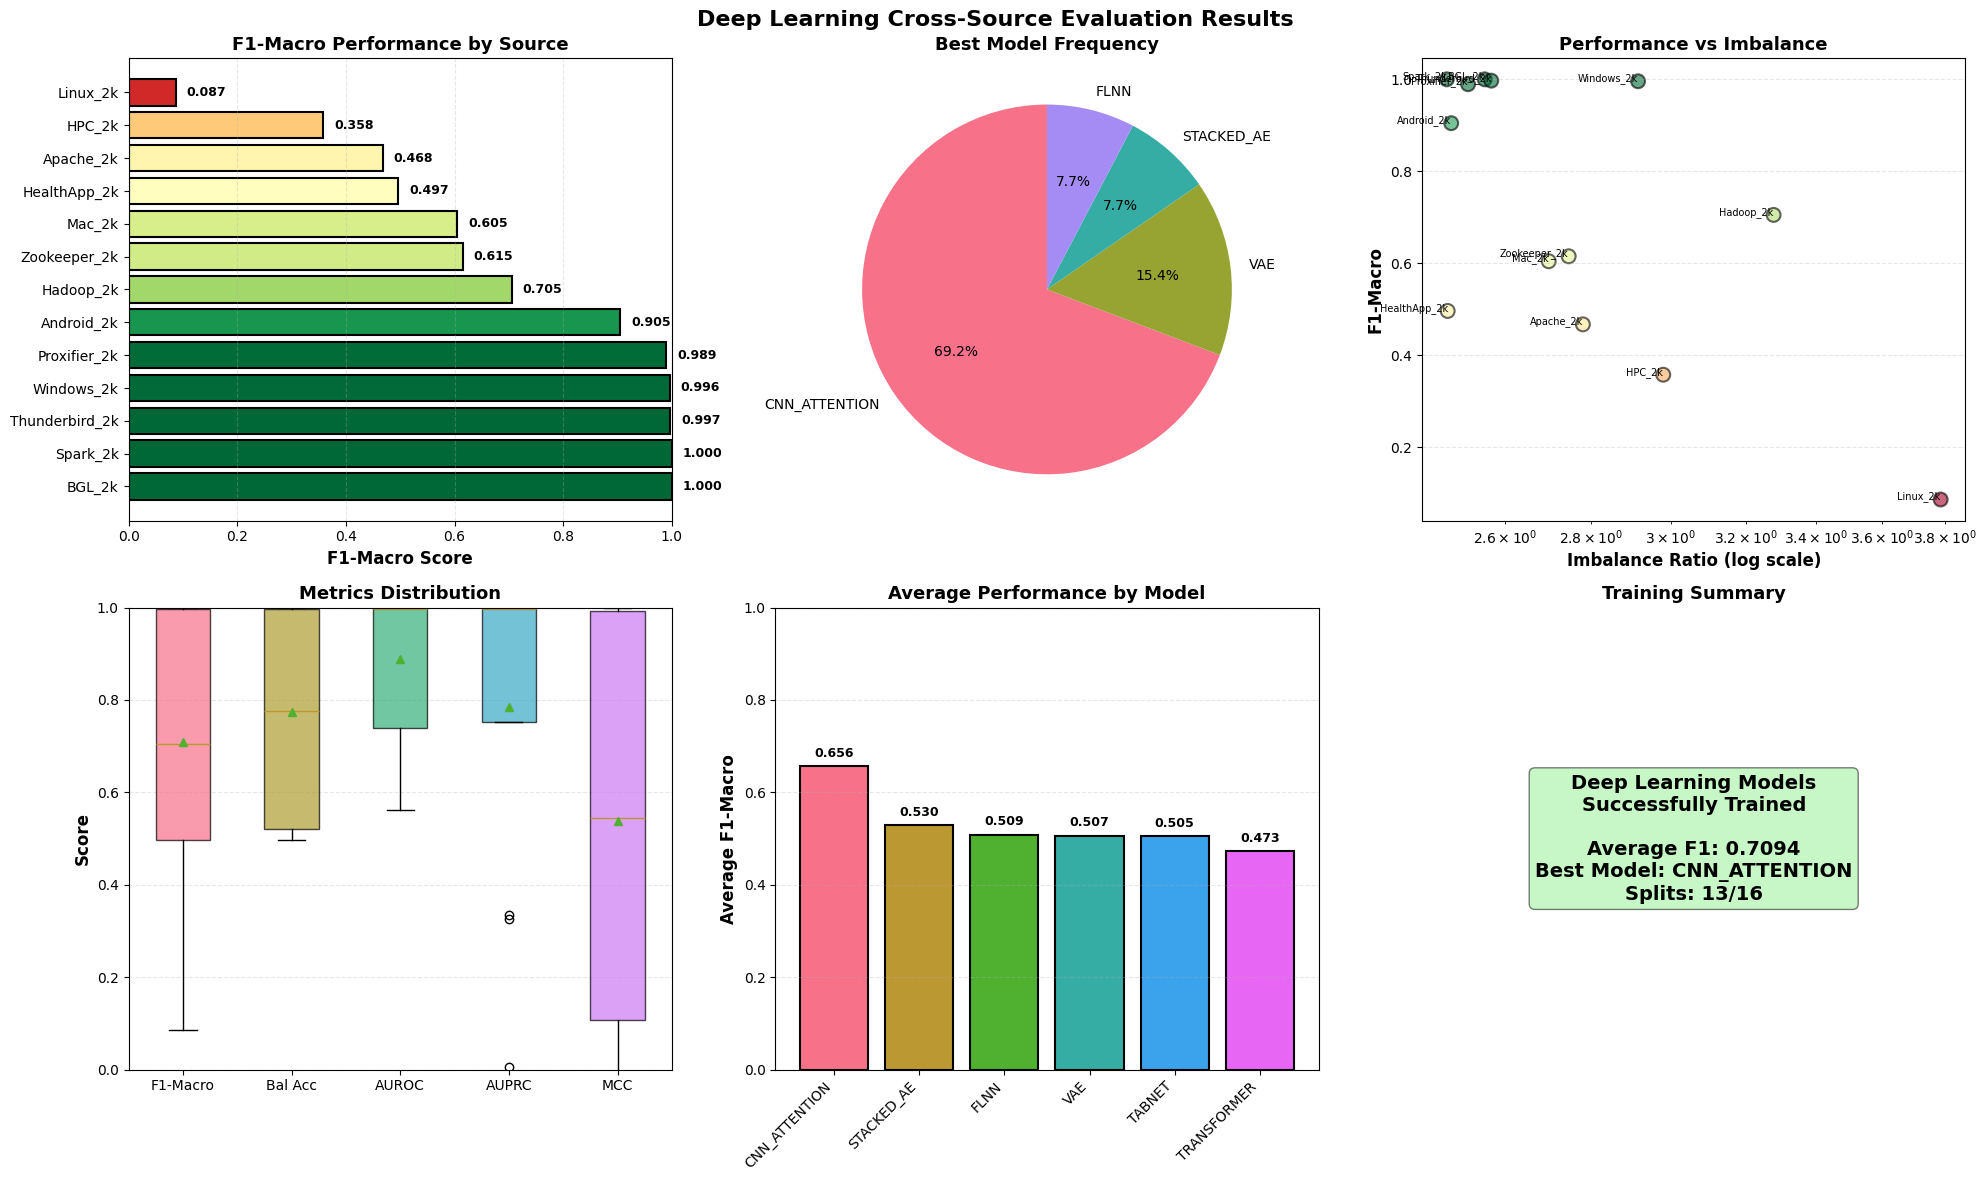

✓ JSON results saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\results\dl_results\aggregate_dl_results_20251120_055741\dl_aggregate_results.json


In [11]:
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80 + "\n")

plt.style.use('default')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Deep Learning Cross-Source Evaluation Results', fontsize=16, fontweight='bold')

# Plot 1: F1-Macro by source
ax1 = axes[0, 0]
sources = df_summary['Test Source'].values
f1_scores = df_summary['F1-Macro'].values
colors = plt.cm.RdYlGn(f1_scores)

bars = ax1.barh(sources, f1_scores, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('F1-Macro Score', fontsize=12, fontweight='bold')
ax1.set_title('F1-Macro Performance by Source', fontsize=13, fontweight='bold')
ax1.set_xlim([0, 1])
ax1.grid(axis='x', alpha=0.3, linestyle='--')

for i, (bar, score) in enumerate(zip(bars, f1_scores)):
    ax1.text(score + 0.02, bar.get_y() + bar.get_height()/2, 
            f'{score:.3f}', va='center', fontsize=9, fontweight='bold')

# Plot 2: Model frequency
ax2 = axes[0, 1]
model_freq = df_summary['Best Model'].value_counts()
ax2.pie(model_freq.values, labels=model_freq.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette("husl", len(model_freq)))
ax2.set_title('Best Model Frequency', fontsize=13, fontweight='bold')

# Plot 3: Performance vs Imbalance
ax3 = axes[0, 2]
imb_ratios = df_summary['Imbalance Ratio'].values
ax3.scatter(imb_ratios, f1_scores, s=100, alpha=0.6, c=f1_scores, 
           cmap='RdYlGn', edgecolors='black', linewidth=1.5)

for i, source in enumerate(sources):
    ax3.annotate(source, (imb_ratios[i], f1_scores[i]), fontsize=7, ha='right')

ax3.set_xlabel('Imbalance Ratio (log scale)', fontsize=12, fontweight='bold')
ax3.set_ylabel('F1-Macro', fontsize=12, fontweight='bold')
ax3.set_title('Performance vs Imbalance', fontsize=13, fontweight='bold')
ax3.set_xscale('log')
ax3.grid(alpha=0.3, linestyle='--')

# Plot 4: Metrics comparison
ax4 = axes[1, 0]
metrics_data = df_summary[['F1-Macro', 'Balanced Acc', 'AUROC', 'AUPRC', 'MCC']].values
bp = ax4.boxplot(metrics_data, labels=['F1-Macro', 'Bal Acc', 'AUROC', 'AUPRC', 'MCC'],
                 patch_artist=True, showmeans=True)

for patch, color in zip(bp['boxes'], sns.color_palette("husl", 5)):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
ax4.set_title('Metrics Distribution', fontsize=13, fontweight='bold')
ax4.grid(axis='y', alpha=0.3, linestyle='--')
ax4.set_ylim([0, 1])

# Plot 5: Per-model average performance
ax5 = axes[1, 1]
model_avg_f1 = {}
for model_name, perf_list in model_performance.items():
    df_model = pd.DataFrame(perf_list)
    model_avg_f1[model_name.upper()] = df_model['f1_macro'].mean()

models_sorted = sorted(model_avg_f1.items(), key=lambda x: x[1], reverse=True)
model_names = [m[0] for m in models_sorted]
model_scores = [m[1] for m in models_sorted]

bars = ax5.bar(model_names, model_scores, color=sns.color_palette("husl", len(model_names)),
               edgecolor='black', linewidth=1.5)
ax5.set_ylabel('Average F1-Macro', fontsize=12, fontweight='bold')
ax5.set_title('Average Performance by Model', fontsize=13, fontweight='bold')
ax5.set_ylim([0, 1])
ax5.grid(axis='y', alpha=0.3, linestyle='--')
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, ha='right')

for bar, score in zip(bars, model_scores):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{score:.3f}', ha='center', fontsize=9, fontweight='bold')

# Plot 6: Performance comparison (DL vs ML baseline)
ax6 = axes[1, 2]
# Placeholder for comparison with ML models
ax6.text(0.5, 0.5, 'Deep Learning Models\nSuccessfully Trained\n\n' + 
         f'Average F1: {df_summary["F1-Macro"].mean():.4f}\n' +
         f'Best Model: {best_overall_model.upper()}\n' +
         f'Splits: {len(all_dl_results)}/{len(splts)}',
         ha='center', va='center', fontsize=14, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
ax6.set_title('Training Summary', fontsize=13, fontweight='bold')
ax6.axis('off')

plt.tight_layout()

viz_file = aggregate_dir / "dl_aggregate_visualization.png"
plt.savefig(viz_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Visualization saved to: {viz_file}")

plt.show()

# Save detailed JSON
results_json = {
    'experiment_info': {
        'timestamp': datetime.now().isoformat(),
        'feature_type': feat_type,
        'num_classes': 2,
        'label_map': LABEL_MAP,
        'total_splits': len(splts),
        'processed_splits': len(all_dl_results),
        'device': str(device),
        'cuda_available': torch.cuda.is_available()
    },
    'aggregate_metrics': {
        'avg_f1_macro': float(df_summary['F1-Macro'].mean()),
        'std_f1_macro': float(df_summary['F1-Macro'].std()),
        'avg_balanced_acc': float(df_summary['Balanced Acc'].mean()),
        'avg_auroc': float(df_summary['AUROC'].mean()),
        'avg_auprc': float(df_summary['AUPRC'].mean()),
        'avg_mcc': float(df_summary['MCC'].mean())
    },
    'best_model': best_overall_model,
    'model_frequency': model_counts.to_dict(),
    'per_model_performance': {
        model_name: {
            'avg_f1': float(pd.DataFrame(perf_list)['f1_macro'].mean()),
            'std_f1': float(pd.DataFrame(perf_list)['f1_macro'].std()),
            'avg_auroc': float(pd.DataFrame(perf_list)['auroc'].mean())
        }
        for model_name, perf_list in model_performance.items()
    }
}

json_file = aggregate_dir / "dl_aggregate_results.json"
with open(json_file, 'w') as f:
    json.dump(results_json, f, indent=2)
print(f"✓ JSON results saved to: {json_file}")

In [12]:
print("\n" + "="*80)
print("DEEP LEARNING EXECUTION COMPLETE")
print("="*80)
print(f"\n📊 Summary:")
print(f"  Splits processed: {len(all_dl_results)}/{len(splts)}")
print(f"  Best overall model: {best_overall_model.upper()}")
print(f"  Average F1-Macro: {df_summary['F1-Macro'].mean():.4f} ± {df_summary['F1-Macro'].std():.4f}")
print(f"  Average Balanced Acc: {df_summary['Balanced Acc'].mean():.4f}")
print(f"  Average AUROC: {df_summary['AUROC'].mean():.4f}")
print(f"\n📁 Results saved to:")
print(f"  Aggregate: {aggregate_dir}")
print(f"  Deployment model: {deployment_file}")
print(f"  Visualization: {viz_file}")
print(f"\n✅ All deep learning models trained successfully!")
print("="*80 + "\n")


DEEP LEARNING EXECUTION COMPLETE

📊 Summary:
  Splits processed: 13/16
  Best overall model: CNN_ATTENTION
  Average F1-Macro: 0.7094 ± 0.3006
  Average Balanced Acc: 0.7746
  Average AUROC: 0.8880

📁 Results saved to:
  Aggregate: C:\Computer Science\AIMLDL\log-anomaly-detection\results\dl_results\aggregate_dl_results_20251120_055741
  Deployment model: C:\Computer Science\AIMLDL\log-anomaly-detection\models\dl_models\deployment\best_dl_model_cnn_attention.pth
  Visualization: C:\Computer Science\AIMLDL\log-anomaly-detection\results\dl_results\aggregate_dl_results_20251120_055741\dl_aggregate_visualization.png

✅ All deep learning models trained successfully!

